# CS440/ECE448 Spring 2023
# MP03: K-nearest Neighbors Model

The first thing you need to do is to download this file: <a href="mp03.zip">mp03.zip</a>.  It has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp03_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `solution.json`: This file contains the solutions for the visible test cases, in <a href="https://docs.python.org/3/library/json.html">JSON</a> format.  If the instructions are confusing you, please look at this file, to see if it can help to clear up your confusion.
* `data`: This directory contains the data.
* `reader.py`: This is an auxiliary program that you can use to read the data.

Please note that there is no extra packages that you should be using except for NumPy. Specifically, you are not allowed to use scikit-learn for this mp(**using the built-in KNN classifier would result in an automatic 0!**)

This file (`mp03_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Reading the data</a>
1. <a href="#section2">Using Numpy</a>
1. <a href="#section3">K-nearest Neighbors</a>
1. <a href="#section4">Prediction and Evaluation</a>
1. <a href="#grade">Grade Your Homework</a>


<a id='section1'></a>

<a id='section1'></a>

<a id='section1'></a>
## Reading the data
The dataset consists of 10000 32x32 colored images total. We have split this data set for you into 2500 development examples and 7500 training examples. The images have their RGB values scaled to range 0-1. This is a subset of the CIFAR-10 dataset, provided by Alex Krizhevsky.

The reader will supply the set of test images as one giant numpy array. The development data is in the same format. So your code must read the dimensions from the input numpy array.

In the dataset, each image is 32x32 and has three (RGB) color channels, yielding 32 * 32 * 3 = 3072 features. However, be aware that synthetic tests in the autograder may have different dimensions. So do not hardcode the dimensions

In [1]:
import reader
help(reader)


Help on module reader:

NAME
    reader - This file is responsible for providing functions for reading the files

FUNCTIONS
    listdir(path=None)
        Return a list containing the names of the files in the directory.
        
        path can be specified as either str, bytes, or a path-like object.  If path is bytes,
          the filenames returned will also be bytes; in all other circumstances
          the filenames returned will be str.
        If path is None, uses the path='.'.
        On some platforms, path may also be specified as an open file descriptor;\
          the file descriptor must refer to a directory.
          If this functionality is unavailable, using it raises NotImplementedError.
        
        The list is in arbitrary order.  It does not include the special
        entries '.' and '..' even if they are present in the directory.
    
    load_dataset(filename, extra=False, sanity_check=False)
        Parameters:
        filename - data file to read
     

We can now load the training and development. Print the first 10 samples to see how the training set looks like. The dev set looks similar to this.

In [2]:
train_images, train_labels, dev_images,dev_labels = reader.load_dataset('mp3_data', extra=True)
print("First 10 of Training Images")
print(train_images[:10])
print("First 10 of Training Labels")
print(train_labels[:10])

First 10 of Training Images
[[0.13333333 0.15294118 0.15686275 ... 0.12941176 0.19215686 0.23529412]
 [0.38823529 0.38431373 0.38431373 ... 0.57647059 0.58039216 0.56862745]
 [0.79607843 0.79215686 0.79607843 ... 0.77647059 0.77647059 0.76862745]
 ...
 [0.36078431 0.38431373 0.40784314 ... 0.60784314 0.67843137 0.65098039]
 [0.90980392 0.67058824 0.39215686 ... 0.05490196 0.16470588 0.2627451 ]
 [1.         1.         1.         ... 0.80392157 0.83137255 0.82745098]]
First 10 of Training Labels
[ True False False False False  True False  True  True  True]


The task is to classify which images contains animals(label True) and which images do not(label False). We could plot first 4 images in training set with `matplotlib`. If you haven't done so, install `matplotlib` first. Note this package is just for visualization purpose and not required for `submitted.py`

In [3]:
!pip install matplotlib

You should consider upgrading via the 'C:\Users\wonde\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


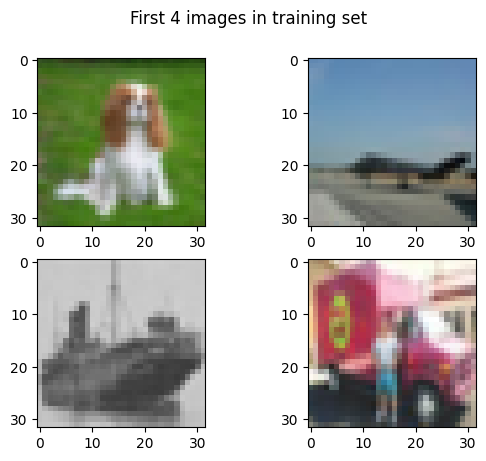

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(img):
    reshaped_img = img.reshape((32, 32, 3),order = 'F')
    rotated_img = np.rot90(reshaped_img, k=1, axes=(1, 0))
    return rotated_img
f, axarr = plt.subplots(2,2)
plt.suptitle("First 4 images in training set")
axarr[0,0].imshow(show_image(train_images[0]))
axarr[0,1].imshow(show_image(train_images[1]))
axarr[1,0].imshow(show_image(train_images[2]))
axarr[1,1].imshow(show_image(train_images[3]))
plt.show()


<a id='section2'></a>

<a id='section2'></a>
## Using numpy
For this MP (unlike some previous MPs), it is much easier to write fast code by using numpy operations. Your data is provided as a numpy array. Use numpy operations as much as possible, until right at the end when you choose a label for each image and produce the output list of labels.

NumPy Tips:

* Running computations on arrays tend to be faster when run using NumPy arrays. If you are having issues with timing out, then consider using a NumPy implementation
* Linear algebra operators (dot product, vector norm, matrix multiplication) are immensely simplified when using NumPy. Consider looking up methods to perform some of these operations if they are needed in your solution.
* <a href="https://numpy.org/doc/stable/user/basics.broadcasting.html">NumPy Broadcasting</a> may make your life easier for this assignment.

<a id='section3'></a>
## K-nearest neighbors
Implement the K-Nearest Neighbor algorithm. See the textbook, lecture notes, and/or <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">Wikipedia</a> page for details. Here is a quick recap. 
Let's start with Nearest Neighbors(NN). 


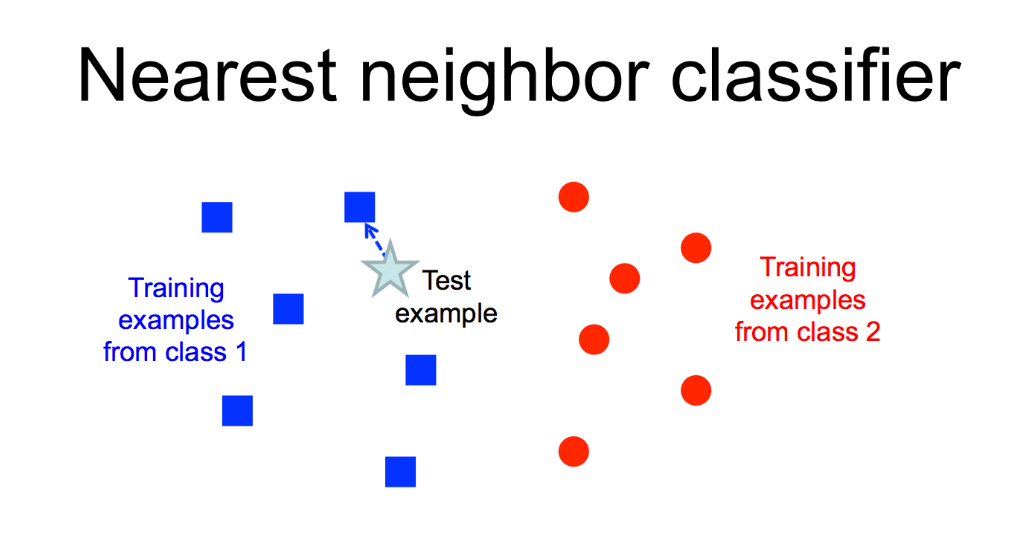 

(Image from Lana Lazebnik)

In the figure above, the test example is classified as blue since the nearest one(measured by Euclidean distance) is blue. Since using one neighbor is prone to overfitting, we could greatly improve this by using K Nearest Neighbors(KNN):

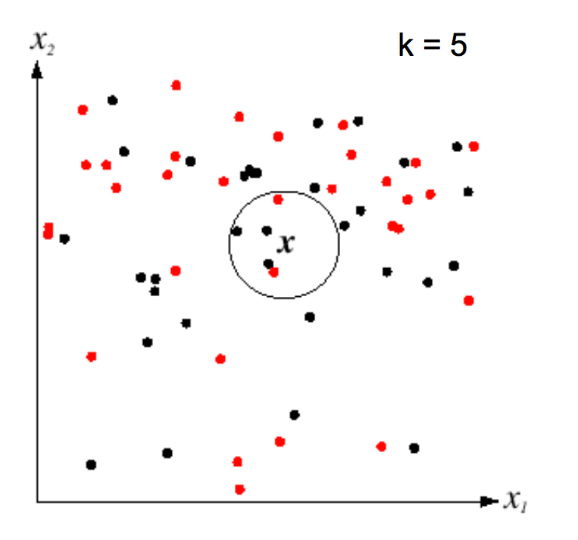

(Image from Lana Lazebnik)




Your implementation should use Euclidean distance. **To break ties, use the negative label (no animal class).** You must implement this algorithm on your own with only standard libraries and NumPy.

Note: To prevent memory errors due to the autograder's limitations, your algorithm should iterate through the list of test images rather than (say) creating a vector containing all the test images.

Our autograder tests will pass in various values for the parameter k. You may not reset k inside your classifier function. For your own understanding, you should experiment with different values of k to see how this affects the accuracy. 

At this point, we'll load the file `submitted.py`.

The file `submitted.py` is the only part of your work that the autograder will see. The only purpose of this notebook is to help you debug `submitted.py`.  Once you have revised `submitted.py` enough to make this notebook work, then you should go to the command line, and type `python grade.py`.  Once that command returns without errors, then  you can go ahead and submit your file `submitted.py` to the autograder.  You can submit to the autograder as often as you want, but it will save you trouble if you debug as much as you can on your local machine, before you submit to the autograder.

We will use `importlib` in order to reload your `submitted.py` over and over again.  That way, every time you make a modification in `submitted.py`, you can just re-run  the corresponding block of this notebook, and it will reload `submitted.py` with your modified code.  

Since the file is called `submitted.py`, python considers it to contain a module called `submitted`.  As shown, you can read the module's docstring by printing `submitted.__doc__`.  You can also type `help(submitted)` to get a lot of information about the module, including its docstring, a list of all the functions it defines, and all of their docstrings.  For  more about docstrings, see, for example, https://www.python.org/dev/peps/pep-0257/.

In [5]:
import submitted
import importlib
importlib.reload(submitted)
print(submitted.__doc__)


This is the module you'll submit to the autograder.

There are several function definitions, here, that raise RuntimeErrors.  You should replace
each "raise RuntimeError" line with a line that performs the function specified in the
function's docstring.



Now it's time for you to open `submitted.py`, and start editing it.  You can open it in another Jupyter window by choosing "Open from Path" from the "File" menu, and then typing `submitted.py`.  Alternatively, you can use any text editor.

Once you have it open, try editing the function `k_nearest_neighbors` so that its functionality matches its docstring.  Your function `k_nearest_neighbors` will take input including one image, train images, train_labels and the number of neighbors used (k). It should return k nearest neighbors of image and k nearest labels.
Here is what it's docstring says:

In [6]:
help(submitted.k_nearest_neighbors)

Help on function k_nearest_neighbors in module submitted:

k_nearest_neighbors(image, train_images, train_labels, k)
    Parameters:
    image - one image
    train_images - a list of N images
    train_labels - a list of N labels corresponding to the N images
    k - the number of neighbors to return
    
    Output:
    neighbors - a list of k images, the k nearest neighbors of image
    labels - a list of k labels corresponding to the k images



Edit `k_nearest_neighbors` so that it does the task specified in its docstring. Note that you are free to change k value multiple times to see if the results change

In [7]:
importlib.reload(submitted)
neighbors, labels = submitted.k_nearest_neighbors(train_images[0], train_images, train_labels, k=2)
print("Top k neighbors")
print(neighbors)
print("\nTop k labels corresponding to k images")
print(labels)


Top k neighbors
[[0.13333333 0.15294118 0.15686275 ... 0.12941176 0.19215686 0.23529412]
 [0.21960784 0.21568627 0.22745098 ... 0.25098039 0.28627451 0.29803922]]

Top k labels corresponding to k images
[ True  True]


<a id='section4'></a>
## Prediction and Evaluation

Once you get your knn function working, you can start to predict with its output(`classify_devset`) and evaluate based on your output(`confusion_matrix`). 
Now, edit the functions `classify_devset` and `confusion_matrix` to finish the task as described in docstring.  The results you should get are shown below, and are also available to you in the file `solutions.json`. 
Let's read the docstring of `classify_devset` first.

In [8]:
help(submitted.classify_devset)

Help on function classify_devset in module submitted:

classify_devset(dev_images, train_images, train_labels, k)
    Parameters:
    dev_images (list) -M images
    train_images (list) -N images
    train_labels (list) -N labels corresponding to the N images
    k (int) - the number of neighbors to use for each dev image
    
    Output:
    hypotheses (list) -one majority-vote labels for each of the M dev images
    scores (list) -number of nearest neighbors that voted for the majority class of each dev image



The `classify_devset` function take development set images, training set images and labels, and number of neighbors as input. You are expected to use `k_nearest_neighbors` implemented from previous step and return predicted labels(Hypotheses) and numbers of nearest neighbors that voted for the majority class of each dev image(scores). 

In [9]:
importlib.reload(submitted)
y_hats,scores = submitted.classify_devset(dev_images, train_images, train_labels, k=2)
print("Hypotheses")
print(y_hats)

Hypotheses
[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


Let's look at the docstring of `confusion_matrix`. 

In [10]:
help(submitted.confusion_matrix)

Help on function confusion_matrix in module submitted:

confusion_matrix(hypotheses, references)
    Parameters:
    hypotheses (list) - a list of M labels output by the classifier
    references (list) - a list of the M correct labels
    
    Output:
    confusions (list of lists, or 2d array) - confusions[m][n] is 
    the number of times reference class m was classified as
    hypothesis class n.
    accuracy (float) - the computed accuracy
    f1(float) - the computed f1 score from the matrix



Taking y_hat(the predicted labels) from previous step and development labels(the ground truth) as input, you are expected to compute a confusion matrix, accuracy and f1. Where
confusion matrix is a 2 * 2 array in this format(you are only expected to return a 2 * 2 array for confusion matrix): 

|             | Predicted 0        | Predicted 1         |    
| ----------- | ------------------ | ------------------- |
| Actual 0    | True Negative(TN)  | False Positive(FP)  |
| Actual 0    | False Negative(FN) | True Positive(TP)   |

Accuracy and F1 score are defined as follows:
$$Precision= \frac{TP} {TP+FP}$$
$$Recall= \frac{TP} {TP+FN}$$
$$Accuracy= \frac{TP+TN} {TP+TN+FP+FN}$$
$$F_1= \frac{2} {\frac{1}{Recall} + \frac{1}{Precision}}$$


In [11]:
importlib.reload(submitted)
confusions, accuracy, f1 = submitted.confusion_matrix(y_hats, dev_labels)
print("Computed confusion matrix:")
print(confusions)
print("The accuracy is:", accuracy)
print("The F1 score is:", f1)

Computed confusion matrix:
[[ 73  34]
 [ 31 112]]
The accuracy is: 0.74
The F1 score is: 0.7750865051903114


<a id='grade'></a>
## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [12]:
!python grade.py

......
----------------------------------------------------------------------
Ran 6 tests in 4.950s

OK


If you got any 'E' marks, it means that your code generated some runtime errors, and you need to debug those.

If you got any 'F' marks, it means that your code ran without errors, but that it generated results that are different from the solutions in `solutions.json`.  Try debugging those differences.

If neither of those things happened, and your result was a series of dots, then your code works perfectly.  

If you're not sure, you can try running grade.py with the -j option.  This will produce a JSON results file, in which the best score you can get is 50.

Now you should try uploading `submitted.py` to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

Gradescope will run the same visible tests that you just ran on your own machine, plus some additional hidden tests.  It's possible that your code passes all the visible tests, but fails the hidden tests.  If that happens, then it probably means that you hard-coded a number into your function definition, instead of using the input parameter that you were supposed to use.  Debug by running your function with a variety of different input parameters, and see if you can get it to respond correctly in all cases.

Once your code works perfectly on Gradescope, with no errors, then you are done with the MP.  Congratulations!

<a id='section3'></a>

<a id='section4'></a>

<a id='grade'></a>